In [3]:
%run setup.ipynb

## Hierarchical clustering

In [4]:
# Function to support searching a scipy tree.

def get_descendant(node, desc_id):
    """Search the descendants of the given node.
    
    Parameters
    ----------
    node : scipy.cluster.hierarchy.ClusterNode
        The ancestor node to search from.
    desc_id : int
        The ID of the node to search for.
        
    Returns
    -------
    desc : scipy.cluster.hierarchy.ClusterNode
        If a node with the given ID is not found, returns None.
    
    """
    if node.id == desc_id:
        return node
    if node.is_leaf():
        return None
    if node.left.id == desc_id:
        return node.left
    if node.right.id == desc_id:
        return node.right
    # search left
    l = get_descendant(node.left, desc_id)
    if l is not None:
        return l
    # search right
    r = get_descendant(node.right, desc_id)
    return r


# monkey-patch as a method
scipy.cluster.hierarchy.ClusterNode.get_descendant = get_descendant

In [5]:
def fig_haplotypes_clustered(h,
                             distance_metric='hamming',
                             linkage_method='single',
                             truncate_distance=0,
                             orientation='top',
                             subplot_ratios=(4, 2),
                             subplot_pad=0,
                             despine_offset=5,
                             count_sort=True,
                             dend_linecolor='k',
                             cut_height=2,
                             highlight_clusters=True,
                             highlight_colors=None,
                             highlight_dend=True,
                             highlight_freq=True,
                             highlight_alpha=0.3,
                             label_clusters=True,
                             dpi=None,
                             fig=None,
                             ):
    """Construct a plot of hierarchical clustering of haplotypes.
    
    Parameters
    ----------
    TODO
    
    Returns
    -------
    TODO
    
    """
    
    # check inputs
    h = allel.HaplotypeArray(h)
    
    # compute distance matrix
    dist = scipy.spatial.distance.pdist(h.T, metric=distance_metric)
    if distance_metric in {'hamming', 'jaccard'}:
        # convert distance to number of SNPs, easier to interpret
        dist *= h.n_variants
    
    # compute hierarchical clustering
    Z = scipy.cluster.hierarchy.linkage(dist, method=linkage_method)

    # Z is a linkage matrix. From the scipy docs...
    # A 4 by (n-1) matrix Z is returned. At the i-th iteration, clusters with 
    # indices Z[i, 0] and Z[i, 1] are combined to form cluster n + i. A cluster 
    # with an index less than n corresponds to one of the original observations. 
    # The distance between clusters Z[i, 0] and Z[i, 1] is given by Z[i, 2]. The 
    # fourth value Z[i, 3] represents the number of original observations in the 
    # newly formed cluster.
    
    # find level to truncate dendrogram
    lastp = h.n_haplotypes - bisect.bisect_right(Z[:, 2], truncate_distance)
    
    # convenience variables
    horizontal = orientation in ['left', 'right']
    vertical = not horizontal
    inverted = orientation in ['bottom', 'right']
    
    # setup figure
    if fig is None:
        figsize = plt.rcParams['figure.figsize']
        if horizontal:
            figsize = figsize[::-1]
        fig = plt.figure(figsize=figsize, dpi=dpi)
        
    # setup gridspec and axes
    if inverted:
        subplot_ratios = subplot_ratios[::-1]
    if horizontal:
        gs = plt.GridSpec(nrows=1, ncols=2, width_ratios=subplot_ratios)
    else:
        gs = plt.GridSpec(nrows=2, ncols=1, height_ratios=subplot_ratios)
    if inverted:
        ax_dend = fig.add_subplot(gs[1])
        ax_freq = fig.add_subplot(gs[0])
    else:
        ax_dend = fig.add_subplot(gs[0])
        ax_freq = fig.add_subplot(gs[1])
    if horizontal:
        sns.despine(ax=ax_dend, offset=despine_offset, 
                    left=True, top=True, right=True, bottom=False)
        sns.despine(ax=ax_freq, offset=despine_offset, 
                    left=True, top=True, right=True, bottom=False)
    else:
        sns.despine(ax=ax_dend, offset=despine_offset, 
                    left=False, top=True, right=True, bottom=True)
        sns.despine(ax=ax_freq, offset=despine_offset, 
                    left=False, top=True, right=True, bottom=True)

    # make a dendrogram
    kwargs_dend = dict(
        truncate_mode='lastp', 
        p=lastp,
        show_leaf_counts=False, 
        count_sort=count_sort, 
        no_labels=True, 
        color_threshold=0, 
        above_threshold_color=dend_linecolor, 
        orientation=orientation
    )    
    dend = scipy.cluster.hierarchy.dendrogram(Z, ax=ax_dend, **kwargs_dend)
    leaves = dend['leaves']
    ax_dend_label = 'Distance'
    if horizontal:
        ax_dend.set_xlabel(ax_dend_label)
        ax_dend.set_yticks([])
    else:
        ax_dend.set_ylabel(ax_dend_label)
        ax_dend.set_xticks([])
        
    # construct a tree and compute observation counts for the dendrogram leaves
    tree = scipy.cluster.hierarchy.to_tree(Z)
    s = np.arange(len(leaves))
    t = np.array([
        1 if l < h.n_haplotypes
        else tree.get_descendant(l).get_count()
        for l in leaves
    ])

    # plot frequencies bar
    ax_freq_label = 'Frequency'
    if horizontal:
        ax_freq.barh(s, t, height=1, lw=0, color='k', align='edge')
        ax_freq.set_ylim(0, len(leaves))
        ax_freq.set_yticks([])
        ax_freq.set_xlabel(ax_freq_label)
        ax_freq.grid(axis='x', lw=.5)
        if orientation == 'right':
            ax_freq.invert_xaxis()
        # remove 0
        ax_freq.set_xticks(ax_freq.get_xticks()[1:])
    else:
        ax_freq.bar(s, t, width=1, lw=0, color='k', align='edge')
        ax_freq.set_xlim(0, len(leaves))
        ax_freq.set_xticks([])
        ax_freq.set_ylabel(ax_freq_label)
        ax_freq.grid(axis='y', lw=.5)
        if orientation == 'top':
            ax_freq.invert_yaxis()
        # remove 0
        ax_freq.set_yticks(ax_freq.get_yticks()[1:])

    # cut the tree
    cut = scipy.cluster.hierarchy.cut_tree(Z, height=cut_height)[:, 0]
    cluster_sizes = np.bincount(cut)
    clusters = [np.nonzero(cut == i)[0] for i in range(cut.max() + 1)]
    
    # now the fiddly bit - we need to figure out where the clusters have
    # ended up in the dendrogram we plotted earlier...
    
    # N.B., the dendrogram was truncated, so each leaf in the dendrogram
    # may correspond to more than one original observation (i.e., haplotype).
    # Let's build a list storing the observations for each leaf:
    leaf_obs = [tree.get_descendant(ix).pre_order() for ix in leaves]
    
    # Now let's figure out for each leaf in the dendrogram, which of the clusters
    # obtained by cutting the tree earlier does it fall into?
    leaf_clusters = np.array([cut[l[0]] for l in leaf_obs])
    
    # Now let's build a data structure that reorders the clusters so they
    # occur in the same order as in the dendrogram, and also record the indices
    # of the start and stop leaf for each cluster:
    cluster_spans = list()
    c_prv = leaf_clusters[0]
    i_start = 0
    for i, c in enumerate(leaf_clusters[1:], 1):
        if c != c_prv:
            cluster_spans.append((i_start, i, clusters[c_prv]))
            i_start = i
        c_prv = c
    # don't forget the last one
    cluster_spans.append((i_start, i+1, clusters[c]))
    
    # OK, now figure out which clusters we want to highlight...
    if isinstance(highlight_clusters, (list, tuple)):
        # user has manually specified which clusters to highlight
        pass
    else:
        # assume highlight_clusters is the minimum cluster size to highlight
        min_cluster_size = int(highlight_clusters)
        highlight_clusters = [i for i, cs in enumerate(cluster_spans) 
                              if len(cs[2]) >= min_cluster_size]
        
    # setup colors for highlighting clusters
    if highlight_colors is None:
        highlight_colors = sns.color_palette('hls', n_colors=len(highlight_clusters))
        
    # do the highlighting
    for color, cix in zip(highlight_colors, highlight_clusters):
        start, stop, _ = cluster_spans[cix]
        if horizontal:
            freq_spanf = ax_freq.axhspan
            dend_patch_xy = (0, start * 10)
            dend_patch_width = cut_height
            dend_patch_height = (stop - start) * 10
        else:
            freq_spanf = ax_freq.axvspan
            dend_patch_xy = (start * 10, 0)
            dend_patch_width = (stop - start) * 10
            dend_patch_height = cut_height
        if highlight_freq:
            freq_spanf(start, stop, color=color, alpha=highlight_alpha, zorder=-20)
        if highlight_dend:
            ax_dend.add_patch(plt.Rectangle(xy=dend_patch_xy, 
                                            width=dend_patch_width, 
                                            height=dend_patch_height, 
                                            color=color, alpha=highlight_alpha, 
                                            zorder=-20))

    # for debugging, label the clusters
    if label_clusters:
        for i, (start, stop, clst) in enumerate(cluster_spans):
            if horizontal:
                x = max(ax_freq.get_xlim())
                y = (start + stop) / 2
                ha = orientation
                va = 'center'
            else:
                x = (start + stop) / 2
                y = max(ax_freq.get_ylim())
                ha = 'center'
                va = orientation
            # treat label_clusters as minimum cluster size to label
            if len(clst) >= int(label_clusters):
                ax_freq.text(x, y, str(i), 
                             va=va, ha=ha, fontsize=6)
    
    # tidy up plot
    if horizontal:
        gs.tight_layout(fig, w_pad=subplot_pad)
    else:
        gs.tight_layout(fig, h_pad=subplot_pad)
    
    # return some useful stuff
    return fig, ax_dend, ax_freq, cluster_spans, leaf_obs


## Haplotype networks (via minimum spanning tree)

In [78]:
def _graph_edges(graph, 
                 edges, 
                 hap_counts, 
                 node_size_factor, 
                 edge_length,
                 anon_width,
                 intermediate_nodes,
                 edge_attrs,
                 anon_node_attrs):
    
    for i in range(edges.shape[0]):

        for j in range(edges.shape[1]):

            # lookup distance between nodes i and j
            sep = edges[i, j]

            if sep > 0:

                # lookup number of haplotypes
                n_i = hap_counts[i]
                n_j = hap_counts[j]

                # calculate node sizes (needed to adjust edge length)
                width_i = np.sqrt(n_i * node_size_factor)
                width_j = np.sqrt(n_j * node_size_factor)

                if sep > 1 and intermediate_nodes:

                    # tricky case, need to add some anonymous nodes to represent intermediate steps

                    # add first intermediate node
                    nid = 'anon_{}_{}_{}'.format(i, j, 0)
                    graph.node(nid, label='', width=str(anon_width), **anon_node_attrs)

                    # add edge from node i to first intermediate
                    el = edge_length + width_i / 2 + anon_width / 2
                    kwargs = {'len': str(el)}
                    kwargs.update(edge_attrs)
                    graph.edge(str(i), 'anon_{}_{}_{}'.format(i, j, 0), **kwargs)

                    # add further intermediate nodes as necessary
                    for k in range(1, sep-1):
                        nid = 'anon_{}_{}_{}'.format(i, j, k)
                        graph.node(nid, label='', width=str(anon_width), **anon_node_attrs)
                        el = edge_length + anon_width
                        kwargs = {'len': str(el)}
                        kwargs.update(edge_attrs)
                        graph.edge('anon_{}_{}_{}'.format(i, j, k-1), 'anon_{}_{}_{}'.format(i, j, k), **kwargs)

                    # add edge from final intermediate node to node j
                    el = edge_length + anon_width / 2 + width_j / 2 
                    kwargs = {'len': str(el)}
                    kwargs.update(edge_attrs)
                    graph.edge('anon_{}_{}_{}'.format(i, j, sep-2), str(j), **kwargs)

                else:

                    # simple case, direct edge from node i to j

                    # N.B., adjust edge length so we measure distance from edge of circle rather than center
                    el = (edge_length * sep) + width_i / 2 + width_j / 2
                    kwargs = {'len': str(el)}
                    kwargs.update(edge_attrs)
                    graph.edge(str(i), str(j), **kwargs)

                    
def graph_haplotype_network(h,
                            hap_colors='grey',
                            distance_metric='hamming',
                            network_method='mst',
                            comment=None,
                            engine='neato',
                            format='png',
                            mode='major',
                            overlap=True,
                            splines=False,
                            node_size_factor=0.01,
                            node_attrs=None,
                            show_node_labels=False,
                            edge_length=0.5,
                            edge_weight=10,
                            edge_attrs=None,
                            show_alternate_edges=True,
                            alternate_edge_attrs=None,
                            anon_width=0.07,
                            anon_fillcolor='white',
                            anon_node_attrs=None,
                            intermediate_nodes=True,
                            max_dist=5,
                            debug=False,
                            ):
    """TODO doc me"""
    
    # check inputs
    h = allel.HaplotypeArray(h)
    
    # find distinct haplotypes
    h_distinct_sets = h.distinct()
    
    # find indices of distinct haplotypes - just need one per set
    h_distinct_indices = sorted([sorted(s)[0] for s in h_distinct_sets])
    
    # obtain an array of distinct haplotypes
    h_distinct = h.take(h_distinct_indices, axis=1)

    # deal with colors - count how many of each color per distinct haplotype
    color_counters = None
    if isinstance(hap_colors, (list, tuple, np.ndarray)):
        assert len(hap_colors) == h.n_haplotypes
        color_counters = [
            collections.Counter([hap_colors[i] for i in s])
            for s in h_distinct_sets
        ]

    # count how many observations per distinct haplotype
    hap_counts = [len(s) for s in h_distinct_sets]

    # compute pairwise distance matrix
    assert distance_metric in ['hamming', 'jaccard']
    dist = allel.pairwise_distance(h_distinct, metric=distance_metric)
    dist *= h.n_variants
    dist = scipy.spatial.distance.squareform(dist).astype(int)

    if network_method.lower() == 'mst':

        # compute minimum spanning tree
        edges = scipy.sparse.csgraph.minimum_spanning_tree(dist).toarray().astype(int)

        # deal with maximum distance
        if max_dist:
            edges[edges > max_dist] = 0

        # no alternate edges when using mst
        alternate_edges = None
        
    elif network_method.lower() == 'msn':
        
        # compute network
        edges, alternate_edges = minimum_spanning_network(dist, max_dist=max_dist, debug=debug)

    # setup graph
    graph = graphviz.Graph(comment=comment, engine=engine, format=format)
    graph.attr('graph', overlap=str(overlap).lower(), splines=str(splines).lower(), mode=mode)

    # add the main nodes
    if node_attrs is None:
        node_attrs = dict()
    node_attrs.setdefault('fixedsize', 'true')
    node_attrs.setdefault('shape', 'circle')
    for i, n in enumerate(hap_counts):
        # TODO iterate over shape of edges, make any extra (median) nodes appear like intermediates

        # calculate width from number of items - make width proportional to area
        width = np.sqrt(n * node_size_factor)

        # determine style and fill color
        if color_counters:
            cc = color_counters[i]
            if len(cc) > 1:
                # more than one color, make a pie chart
                style = 'wedged'
                fillcolor = ':'.join(['%s;%s' % (k, v/n) for k, v in cc.items()])
            else:
                # just one color, fill with solid color
                style = 'filled'
                fillcolor = list(cc.keys())[0]
        else:
            style = 'filled'
            fillcolor = hap_colors

        # add graph node
        if show_node_labels:
            label = str(i)
        else:
            label = ""
        kwargs = dict()
        kwargs.update(node_attrs)
        kwargs.setdefault('style', style)
        kwargs.setdefault('fillcolor', fillcolor)
        kwargs.setdefault('label', label)
        kwargs.setdefault('width', str(width))
        graph.node(str(i), **kwargs)
    
    # setup defaults
    if anon_node_attrs is None:
        anon_node_attrs = dict()
    anon_node_attrs.setdefault('fixedsize', 'true')
    anon_node_attrs.setdefault('shape', 'circle')
    anon_node_attrs.setdefault('style', 'filled')
    anon_node_attrs.setdefault('fillcolor', anon_fillcolor)
    if edge_attrs is None:
        edge_attrs = dict()
    edge_attrs.setdefault('style', 'normal')
    edge_attrs.setdefault('weight', str(edge_weight))
    if alternate_edge_attrs is None:
        alternate_edge_attrs = dict()
    alternate_edge_attrs.setdefault('style', 'dashed')
    alternate_edge_attrs.setdefault('weight', str(edge_weight))

    # add main edges
    _graph_edges(graph, 
                 edges, 
                 hap_counts, 
                 node_size_factor, 
                 edge_length,
                 anon_width,
                 intermediate_nodes,
                 edge_attrs,
                 anon_node_attrs)
    
    # add alternate edges
    if show_alternate_edges and alternate_edges is not None:
        _graph_edges(graph, 
                     alternate_edges, 
                     hap_counts, 
                     node_size_factor, 
                     edge_length,
                     anon_width,
                     intermediate_nodes,
                     alternate_edge_attrs,
                     anon_node_attrs)

    return graph

In [106]:
def minimum_spanning_network(dist, max_dist=None, debug=False):
    """TODO"""
    
    # TODO review implementation, see if this can be tidied up
    
    # keep only the lower triangle of the distance matrix, to avoid adding the same
    # edge twice
    dist = np.triu(dist)
    
    # setup the output array of links between nodes
    edges = np.zeros_like(dist)
    
    # setup an array of alternate links
    alternate_edges = np.zeros_like(dist)
    
    # intermediate variable - assignment of haplotypes to clusters (a.k.a. sub-networks)
    # initially each distinct haplotype is in its own cluster
    cluster = np.arange(dist.shape[0])
    
    # start with haplotypes separated by a single mutation
    step = 1
    
    # iterate until all haplotypes in a single cluster, or max_dist reached
    while len(set(cluster)) > 1 and (max_dist is None or step <= max_dist):
        if debug: print('processing step', step, cluster)
            
        # keep track of which clusters have been merged at this height
        merged = set()
        
        # remember what cluster assignments were at the previous height
        prv_cluster = cluster.copy()
        
        # iterate over all pairs where distance equals current step size
        for i, j in zip(*np.nonzero(dist == step)):
            if debug: print('found potential edge', i, j)
            
            # current cluster assignment for each haplotype
            a = cluster[i]
            b = cluster[j]
            
            # previous cluster assignment for each haplotype
            pa = prv_cluster[i]
            pb = prv_cluster[j]
            
            if debug: print(a, b, pa, pb, merged)
            
            # check to see if both nodes already in the same cluster
            if a != b:
                
                # nodes are in different clusters, so we can merge (i.e., connect) the clusters
                
                if debug: print('assign an edge')
                edges[i, j] = dist[i, j]
                
                # merge clusters
                c = cluster.max() + 1
                loc_a = cluster == a
                loc_b = cluster == b
                cluster[loc_a] = c
                cluster[loc_b] = c
                merged.add(tuple(sorted([pa, pb])))
                if debug: print('merged', cluster, merged)

            elif tuple(sorted([pa, pb])) in merged or step == 1:
                
                # the two clusters have already been merged at this level, this is an alternate connection
                # N.B., special case step = 1 because no previous cluster assignments
                
                if debug: print('assign an alternate edge')
                alternate_edges[i, j] = dist[i, j]
                
            else:
                
                if debug: print('')
                    
        # increment step
        step += 1
                
    return edges, alternate_edges

## Sandbox

In [271]:
h = allel.HaplotypeArray([[0, 1, 1, 0],
                          [0, 1, 0, 1],
                          [0, 0, 1, 1],
                          [0, 0, 1, 0],
                          [0, 0, 0, 1]])
h = h[:, :4]

In [272]:
dist = allel.pairwise_distance(h, metric='hamming')
dist *= h.n_variants
dist = scipy.spatial.distance.squareform(dist).astype(int)
dist

array([[0, 2, 3, 3],
       [2, 0, 3, 3],
       [3, 3, 0, 4],
       [3, 3, 4, 0]])

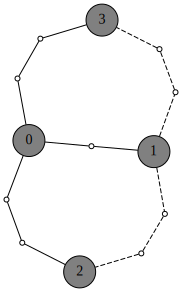

In [273]:
graph_haplotype_network(h, network_method='msn', show_node_labels=True, node_size_factor=0.2, debug=False, max_dist=3)

In [274]:
n_haps = h.n_haplotypes
n_haps

4

In [275]:
h_aug = allel.HaplotypeArray(h.copy())

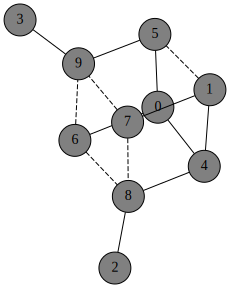

In [297]:
graph_haplotype_network(h_aug, network_method='msn', show_node_labels=True, node_size_factor=0.2, debug=False, max_dist=None)

In [291]:
n_haps_aug = h_aug.n_haplotypes

In [292]:
dist_aug = allel.pairwise_distance(h_aug, metric='hamming')
dist_aug *= h.n_variants
dist_aug = scipy.spatial.distance.squareform(dist_aug).astype(int)
dist_aug

array([[0, 2, 3, 3, 1, 1, 1, 3, 2, 2],
       [2, 0, 3, 3, 1, 1, 3, 1, 2, 2],
       [3, 3, 0, 4, 2, 4, 2, 2, 1, 3],
       [3, 3, 4, 0, 4, 2, 2, 2, 3, 1],
       [1, 1, 2, 4, 0, 2, 2, 2, 1, 3],
       [1, 1, 4, 2, 2, 0, 2, 2, 3, 1],
       [1, 3, 2, 2, 2, 2, 0, 2, 1, 1],
       [3, 1, 2, 2, 2, 2, 2, 0, 1, 1],
       [2, 2, 1, 3, 1, 3, 1, 1, 0, 2],
       [2, 2, 3, 1, 3, 1, 1, 1, 2, 0]])

In [293]:
edges, alt_edges = minimum_spanning_network(dist_aug)
edges

array([[0, 0, 0, 0, 1, 1, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [294]:
alt_edges

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [295]:
all_edges = edges + alt_edges
all_edges

array([[0, 0, 0, 0, 1, 1, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 1, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [296]:
for i, j, k in itertools.combinations(range(n_haps_aug), 3): 
    n_medians_added = 0
    print(i, j, k)
    n_pairs_linked = 0
    n_pairs_linked += all_edges[i, j] > 0
    n_pairs_linked += all_edges[i, k] > 0
    n_pairs_linked += all_edges[j, k] > 0
    print('n_pairs_linked', n_pairs_linked)
    if n_pairs_linked >= 2:
        print('computing median vector')
        uvw = h_aug[:, [i, j, k]]
        uvw_ac = uvw.count_alleles(max_allele=1)
        x = np.argmax(uvw_ac, axis=1)
        print('median vector', x)
        # TODO test if x already in haps_aug
        if np.any(np.all(x[:, None] == np.asarray(h_aug), axis=0)):
            print('median vector already present')
        else:
            print('adding median vector')
            h_aug = allel.HaplotypeArray(np.column_stack([h_aug, x]))
            n_medians_added += 1
    print(n_medians_added)
        

0 1 2
n_pairs_linked 0
0
0 1 3
n_pairs_linked 0
0
0 1 4
n_pairs_linked 2
computing median vector
median vector [1 0 0 0 0]
median vector already present
0
0 1 5
n_pairs_linked 2
computing median vector
median vector [0 1 0 0 0]
median vector already present
0
0 1 6
n_pairs_linked 1
0
0 1 7
n_pairs_linked 1
0
0 1 8
n_pairs_linked 0
0
0 1 9
n_pairs_linked 0
0
0 2 3
n_pairs_linked 0
0
0 2 4
n_pairs_linked 1
0
0 2 5
n_pairs_linked 1
0
0 2 6
n_pairs_linked 1
0
0 2 7
n_pairs_linked 0
0
0 2 8
n_pairs_linked 1
0
0 2 9
n_pairs_linked 0
0
0 3 4
n_pairs_linked 1
0
0 3 5
n_pairs_linked 1
0
0 3 6
n_pairs_linked 1
0
0 3 7
n_pairs_linked 0
0
0 3 8
n_pairs_linked 0
0
0 3 9
n_pairs_linked 1
0
0 4 5
n_pairs_linked 2
computing median vector
median vector [0 0 0 0 0]
median vector already present
0
0 4 6
n_pairs_linked 2
computing median vector
median vector [0 0 0 0 0]
median vector already present
0
0 4 7
n_pairs_linked 1
0
0 4 8
n_pairs_linked 2
computing median vector
median vector [1 0 0 0 0]
median 